# Combined Deep Q-Network (DQN) for LunarLander-v2

This notebook is an implementation of a Deep Q-Network to tackle the "LunarLander-v2" environment in OpenAI Gym. The DQN will learn to land a spacecraft safely on the lunar surface. The goal is to achieve an average score of 195 or above over the last 50 episodes.

### Import Libraries

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import os
import renderlab
import itertools

### Define the Hyperparameters

Setting up hyperparameters like learning rate, batch size, exploration rates, and defining the file path for saving the trained DQN model.

In [2]:
# Define the Parameters
GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
LEARNING_RATE = 0.0005
solved_score = 195 

In [3]:
model_save_path = 'models/combined_dqn_lunarlander_model.pth'

# Create the 'models' directory if it doesn't exist
model_directory = os.path.dirname(model_save_path)
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
    
folder_path = 'average_scores/'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

### Noisy Linear Layer

In [ ]:
# Noisy Linear Layer
class NoisyLinear(nn.Module):
    def __init__(self, in_size, out_size):
        super(NoisyLinear, self).__init__()
        self.w_mu = nn.Parameter(torch.empty((out_size, in_size)))
        self.w_sigma = nn.Parameter(torch.empty((out_size, in_size)))
        self.b_mu = nn.Parameter(torch.empty((out_size)))
        self.b_sigma = nn.Parameter(torch.empty((out_size)))
        uniform_(self.w_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))
        uniform_(self.b_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))
        nn.init.constant_(self.w_sigma, 0.017)
        nn.init.constant_(self.b_sigma, 0.017)

    def forward(self, x, sigma=1):
        if self.training:
            w_noise = torch.normal(0, sigma, size=self.w_mu.size())
            b_noise = torch.normal(0, sigma, size=self.b_mu.size())
            return F.linear(x, self.w_mu + self.w_sigma * w_noise, self.b_mu + self.b_sigma * b_noise)
        else:
            return F.linear(x, self.w_mu, self.b_mu)

### Combined DQN Model

Below is the neural network that will approximate the Q-value function. The network will take the state as input and output Q-values for each action.

In [4]:
# Combined DQN Model
class CombinedDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(CombinedDQN, self).__init__()
        self.fc1 = NoisyLinear(state_size, 64)
        self.fc2 = NoisyLinear(64, 64)
        self.fc3 = NoisyLinear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Memory

Using a replay memory to store transitions that the agent observes, allowing to reuse this data later. This helps in breaking the correlation between consecutive learning samples.

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### DQN Agent Class

Encapsulating the learning mechanisms of the DQN agent, including action selection, model optimization, and interaction with the replay memory, along with managing the exploration rate decay.

In [6]:
# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPS_START
        self.policy_net = CombinedDQN(state_size, action_size)
        self.target_net = CombinedDQN(state_size, action_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayMemory(BUFFER_SIZE)

    def select_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return

        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, dtype=torch.float32)

        # Get Q values for current states
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Double DQN update starts here
        # Select best action in next state using the policy network
        next_state_actions = self.policy_net(non_final_next_states).max(1)[1].unsqueeze(1)

        # Get the Q value of this best action from the target network
        next_state_values = torch.zeros(BATCH_SIZE)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).gather(1, next_state_actions).squeeze(1)
        # Double DQN update ends here

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) * (1 - done_batch) + reward_batch

        # Compute loss
        loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(EPS_END, EPS_DECAY * self.epsilon)

### Training Loop

Runs the LunarLander-v2 environment for a set number of episodes, gathering experiences and optimizing the agent's policy network based on these experiences.

In [7]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

scores = []
average_scores = []
max_steps_per_episode = 2000  # Maximum steps per episode to prevent very long episodes
solved_score = 195  # Solved condition threshold
solved = False  # Flag to indicate whether the environment is solved

# Wrap the episode range with tqdm for the progress bar
for i_episode in itertools.count():
    state_tuple = env.reset()
    state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
    state = torch.from_numpy(state).float().unsqueeze(0)
    total_reward = 0
    done = False
    step_count = 0  # Step counter for each episode

    while not done and step_count < max_steps_per_episode:
        action = agent.select_action(state)
        output = env.step(action.item())
        next_state = output[0]
        reward = output[1]
        done = output[2]

        next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        reward_tensor = torch.tensor([reward], dtype=torch.float)

        agent.memory.push(state, action, next_state, reward_tensor, done)
        state = next_state
        total_reward += reward
        agent.optimize_model()

        step_count += 1

    agent.update_target_net()
    agent.decay_epsilon()
    scores.append(total_reward)

    # Calculate average score of the last 50 episodes
    if len(scores) >= 50:
        avg_score_last_50 = np.mean(scores[-50:])
        average_scores.append(avg_score_last_50)

        # Check if the environment is solved
        if avg_score_last_50 >= solved_score and not solved:
            print("*"*125)
            print(f"Solved at episode: {i_episode} - Average score over the last 50 episodes: {avg_score_last_50}")
            torch.save(agent.policy_net.state_dict(), model_save_path)
            print("*"*125)
            print(f"Model successfully saved to {model_save_path}")
            solved = True
            break  # Stop training since the environment is considered solved

    # Output progress every 10 episodes
    if i_episode % 10 == 0:
        # Calculate the average of the last 10 episodes
        avg_score_last_10 = np.mean(scores[-10:])
        print(f"Episode {i_episode}, Average Score Last 10 Episodes: {avg_score_last_10}")
    
    # Output progress for every episode
    #print(f"Episode {i_episode}, Score: {total_reward}")
    
# Save the file
np.save(folder_path + 'average_scores_combined.npy', average_scores)  

env.close()

Episode 0, Average Score Last 10 Episodes: -460.2098500229309
Episode 10, Average Score Last 10 Episodes: -157.6583870975871
Episode 20, Average Score Last 10 Episodes: -165.33187489592055
Episode 30, Average Score Last 10 Episodes: -130.73207262690136
Episode 40, Average Score Last 10 Episodes: -96.27886914085227
Episode 50, Average Score Last 10 Episodes: -97.85256698195937
Episode 60, Average Score Last 10 Episodes: -106.19076832581297
Episode 70, Average Score Last 10 Episodes: -54.071189753144765
Episode 80, Average Score Last 10 Episodes: -68.56986236666069
Episode 90, Average Score Last 10 Episodes: -58.89375336674836
Episode 100, Average Score Last 10 Episodes: -49.63842961954844
Episode 110, Average Score Last 10 Episodes: -42.11470858835865
Episode 120, Average Score Last 10 Episodes: -47.977002002819326
Episode 130, Average Score Last 10 Episodes: -74.69421382811375
Episode 140, Average Score Last 10 Episodes: -44.54808206765127
**********************************************

### Training Progress Visualization

Visualizing the training progress with a plot of the average reward per episode (Y-axis) against the number of episodes (X-axis).

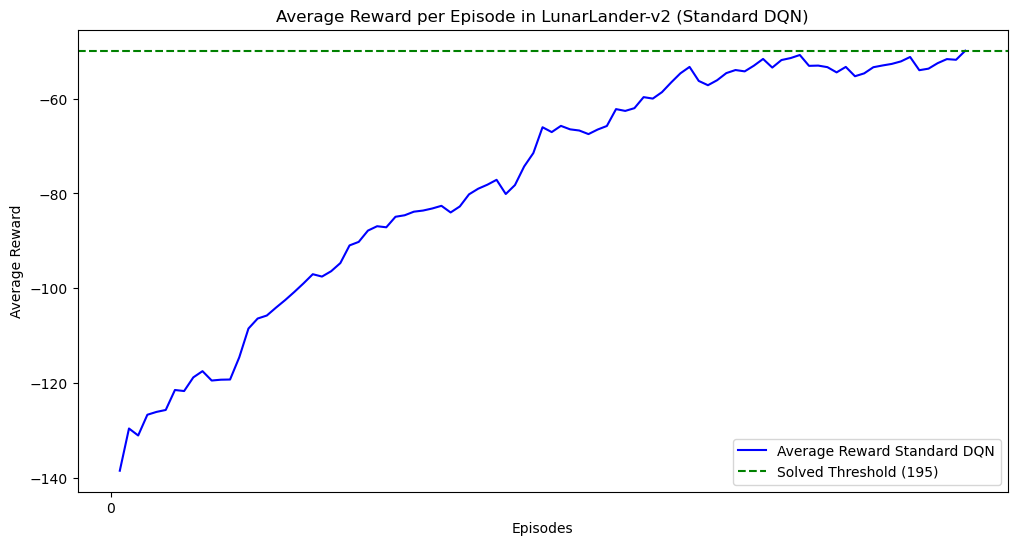

In [8]:
# Creating the plot
episode_numbers = list(range(10, len(average_scores) * 10 + 1, 10))

plt.figure(figsize=(12, 6))
plt.plot(episode_numbers, average_scores, label='Average Reward Combined DQN', color='Pink')
plt.axhline(y=solved_score, color='green', linestyle='--', label='Solved Threshold (195)')

# Set x-axis labels to show every 100 episodes
plt.xticks(range(0, len(average_scores) + 1, 100))

plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode in LunarLander-v2 (Combined DQN)')
plt.legend()
plt.show()

In [9]:
## Initialize the environment
#env = gym.make('LunarLander-v2', render_mode='rgb_array')
#
## Wrap the environment with RenderFrame from renderlab to record video
#env = renderlab.RenderFrame(env, "./video")
#
## Initialize your DQN agent here
#state_size = env.observation_space.shape[0]
#action_size = env.action_space.n
#agent = DQNAgent(state_size, action_size)
#agent.policy_net.load_state_dict(torch.load(model_save_path))
#
## Reset the environment and get the initial observation
#obs, info = env.reset()
#
#while True:
#    # Convert the observation to a tensor and pass it to the agent to select an action
#    obs_tensor = torch.from_numpy(obs).float().unsqueeze(0)
#    action = agent.select_action(obs_tensor).item()
#
#    # Take the action in the environment
#    obs, reward, terminated, truncated, info = env.step(action)
#
#    # Check if the episode is done
#    if terminated or truncated:
#        break
#
## Play the recorded video
#env.play()